# Twitter Sentiment Analysis

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/zd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Settings

In [3]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
#ISO-8859-1
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

### Read Dataset

### Dataset details
* **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
* **ids**: The id of the tweet ( 2087)
* **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
* **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
* **user**: the user that tweeted (robotickilldozr)
* **text**: the text of the tweet (Lyx is cool)

In [4]:
dataset_filename = os.listdir("input")[0]
dataset_path = os.path.join("input",dataset_filename)
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)

('Open file:', 'input/training.1600000.processed.noemoticon.csv')


In [5]:
print("Dataset size:", len(df))

('Dataset size:', 1600000)


In [6]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
df.flag.unique()

array([u'NO_QUERY'], dtype=object)

### Map target label to String
* **0** -> **NEGATIVE**
* **2** -> **NEUTRAL**
* **4** -> **POSITIVE**

In [8]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [9]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 342 ms, sys: 19.4 ms, total: 361 ms
Wall time: 335 ms


Text(0.5,1,u'Dataset labels distribuition')

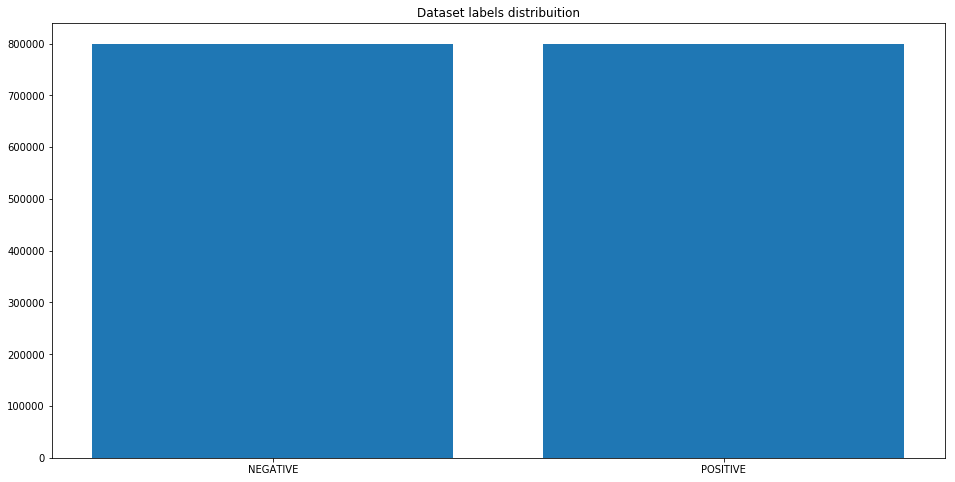

In [10]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

### Pre-Process dataset

In [11]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text.encode("utf-8")).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
df.shape

(1600000, 6)

In [15]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 3min 29s, sys: 615 ms, total: 3min 30s
Wall time: 3min 27s


### Split train and test

In [16]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

('TRAIN size:', 1280000)
('TEST size:', 320000)


### Word2Vec 

In [17]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 1.52 s, sys: 82 ms, total: 1.6 s
Wall time: 1.49 s


In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [19]:
w2v_model.build_vocab(documents)

2019-03-12 14:00:17,425 : INFO : collecting all words and their counts
2019-03-12 14:00:17,428 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-03-12 14:00:17,464 : INFO : PROGRESS: at sentence #10000, processed 72565 words, keeping 14005 word types
2019-03-12 14:00:17,481 : INFO : PROGRESS: at sentence #20000, processed 144393 words, keeping 21587 word types
2019-03-12 14:00:17,493 : INFO : PROGRESS: at sentence #30000, processed 215826 words, keeping 27541 word types
2019-03-12 14:00:17,503 : INFO : PROGRESS: at sentence #40000, processed 288271 words, keeping 32764 word types
2019-03-12 14:00:17,512 : INFO : PROGRESS: at sentence #50000, processed 359772 words, keeping 37587 word types
2019-03-12 14:00:17,521 : INFO : PROGRESS: at sentence #60000, processed 431431 words, keeping 42198 word types
2019-03-12 14:00:17,531 : INFO : PROGRESS: at sentence #70000, processed 503103 words, keeping 46458 word types
2019-03-12 14:00:17,540 : INFO : PROGRESS: at s

2019-03-12 14:00:18,217 : INFO : PROGRESS: at sentence #720000, processed 5193881 words, keeping 200325 word types
2019-03-12 14:00:18,227 : INFO : PROGRESS: at sentence #730000, processed 5265467 words, keeping 202133 word types
2019-03-12 14:00:18,238 : INFO : PROGRESS: at sentence #740000, processed 5337518 words, keeping 203818 word types
2019-03-12 14:00:18,248 : INFO : PROGRESS: at sentence #750000, processed 5409321 words, keeping 205535 word types
2019-03-12 14:00:18,258 : INFO : PROGRESS: at sentence #760000, processed 5481512 words, keeping 207282 word types
2019-03-12 14:00:18,270 : INFO : PROGRESS: at sentence #770000, processed 5554093 words, keeping 209076 word types
2019-03-12 14:00:18,281 : INFO : PROGRESS: at sentence #780000, processed 5625382 words, keeping 210805 word types
2019-03-12 14:00:18,294 : INFO : PROGRESS: at sentence #790000, processed 5698066 words, keeping 212618 word types
2019-03-12 14:00:18,307 : INFO : PROGRESS: at sentence #800000, processed 577088

In [20]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

('Vocab size', 30369)


In [21]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)


2019-03-12 14:00:19,510 : INFO : training model with 8 workers on 30369 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2019-03-12 14:00:20,528 : INFO : EPOCH 1 - PROGRESS: at 19.73% examples, 1605043 words/s, in_qsize 15, out_qsize 1
2019-03-12 14:00:21,537 : INFO : EPOCH 1 - PROGRESS: at 40.73% examples, 1659507 words/s, in_qsize 15, out_qsize 0
2019-03-12 14:00:22,540 : INFO : EPOCH 1 - PROGRESS: at 60.74% examples, 1653948 words/s, in_qsize 15, out_qsize 1
2019-03-12 14:00:23,542 : INFO : EPOCH 1 - PROGRESS: at 81.01% examples, 1656397 words/s, in_qsize 16, out_qsize 1
2019-03-12 14:00:24,399 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-12 14:00:24,400 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-12 14:00:24,401 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-12 14:00:24,403 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-12 14:00:24,404 : 

2019-03-12 14:00:50,974 : INFO : EPOCH 7 - PROGRESS: at 40.40% examples, 1651585 words/s, in_qsize 15, out_qsize 0
2019-03-12 14:00:51,976 : INFO : EPOCH 7 - PROGRESS: at 60.31% examples, 1646138 words/s, in_qsize 15, out_qsize 1
2019-03-12 14:00:52,977 : INFO : EPOCH 7 - PROGRESS: at 81.01% examples, 1659724 words/s, in_qsize 15, out_qsize 0
2019-03-12 14:00:53,853 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-12 14:00:53,854 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-12 14:00:53,856 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-12 14:00:53,857 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-12 14:00:53,858 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-12 14:00:53,862 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-12 14:00:53,863 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-12 14:00:5

2019-03-12 14:01:22,389 : INFO : EPOCH 13 - PROGRESS: at 81.55% examples, 1669546 words/s, in_qsize 16, out_qsize 1
2019-03-12 14:01:23,241 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-12 14:01:23,243 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-12 14:01:23,244 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-12 14:01:23,245 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-12 14:01:23,254 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-12 14:01:23,255 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-12 14:01:23,257 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-12 14:01:23,258 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-12 14:01:23,260 : INFO : EPOCH - 13 : training on 9227203 raw words (8222528 effective words) took 4.9s, 1681631 effective words/s
2019-03-12 14:01:

2019-03-12 14:01:52,673 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-12 14:01:52,674 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-12 14:01:52,675 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-03-12 14:01:52,678 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-12 14:01:52,680 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-12 14:01:52,681 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-12 14:01:52,688 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-12 14:01:52,689 : INFO : EPOCH - 19 : training on 9227203 raw words (8222996 effective words) took 4.9s, 1663799 effective words/s
2019-03-12 14:01:53,701 : INFO : EPOCH 20 - PROGRESS: at 19.30% examples, 1575607 words/s, in_qsize 16, out_qsize 0
2019-03-12 14:01:54,707 : INFO : EPOCH 20 - PROGRESS: at 39.97% examples, 1637037 words/s, in_qsize 14, out_

2019-03-12 14:02:22,126 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-03-12 14:02:22,129 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-03-12 14:02:22,134 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-03-12 14:02:22,135 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-12 14:02:22,136 : INFO : EPOCH - 25 : training on 9227203 raw words (8223001 effective words) took 4.9s, 1678516 effective words/s
2019-03-12 14:02:23,151 : INFO : EPOCH 26 - PROGRESS: at 19.62% examples, 1604460 words/s, in_qsize 15, out_qsize 0
2019-03-12 14:02:24,158 : INFO : EPOCH 26 - PROGRESS: at 39.97% examples, 1635849 words/s, in_qsize 16, out_qsize 0
2019-03-12 14:02:25,164 : INFO : EPOCH 26 - PROGRESS: at 60.52% examples, 1652271 words/s, in_qsize 14, out_qsize 0
2019-03-12 14:02:26,161 : INFO : EPOCH 26 - PROGRESS: at 80.58% examples, 1650692 words/s, in_qsize 15, out_qsize 0
2019-03-12 14:02:27,054 : INFO : 

2019-03-12 14:02:51,574 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-03-12 14:02:51,575 : INFO : EPOCH - 31 : training on 9227203 raw words (8222615 effective words) took 4.9s, 1683860 effective words/s
2019-03-12 14:02:52,589 : INFO : EPOCH 32 - PROGRESS: at 19.40% examples, 1593014 words/s, in_qsize 14, out_qsize 0
2019-03-12 14:02:53,590 : INFO : EPOCH 32 - PROGRESS: at 40.08% examples, 1642523 words/s, in_qsize 16, out_qsize 0
2019-03-12 14:02:54,594 : INFO : EPOCH 32 - PROGRESS: at 60.63% examples, 1658534 words/s, in_qsize 15, out_qsize 0
2019-03-12 14:02:55,593 : INFO : EPOCH 32 - PROGRESS: at 81.34% examples, 1668569 words/s, in_qsize 15, out_qsize 0
2019-03-12 14:02:56,461 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-03-12 14:02:56,462 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-03-12 14:02:56,464 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-03-12 14:02:56,465 : INFO : 

CPU times: user 11min 44s, sys: 8.76 s, total: 11min 53s
Wall time: 2min 36s


(263123509, 295270496)

In [22]:
w2v_model.most_similar("love")

/home/aqz/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2019-03-12 14:02:56,493 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5722876787185669),
 ('loves', 0.5650951862335205),
 ('loved', 0.5347206592559814),
 ('adore', 0.5191938877105713),
 ('amazing', 0.5122210383415222),
 ('looove', 0.48154544830322266),
 ('awesome', 0.46200868487358093),
 ('lovee', 0.4488353133201599),
 ('loveee', 0.4456603527069092),
 ('loooove', 0.43627434968948364)]

### Tokenize Text

In [23]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

('Total words', 290418)
CPU times: user 10.3 s, sys: 163 ms, total: 10.5 s
Wall time: 10.2 s


In [24]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 10.1 s, sys: 315 ms, total: 10.4 s
Wall time: 10.2 s


### Label Encoder 

In [25]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [26]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

('y_train', (1280000, 1))
('y_test', (320000, 1))


In [27]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

('x_train', (1280000, 300))
('y_train', (1280000, 1))
()
('x_test', (320000, 300))
('y_test', (320000, 1))


In [28]:
y_train[:10]

array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [35]:
import gc

In [36]:
gc.collect()

195

### Embedding layer

In [37]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290418, 300)


In [38]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

### Build Model

In [39]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 300)          87125400  
_________________________________________________________________
dropout_2 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 87,285,901
Trainable params: 160,501
Non-trainable params: 87,125,400
_________________________________________________________________


### Compile model

In [40]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

### Callbacks

In [41]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

### Train

In [42]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/8
1152000/1152000 [==============================] - 356s 309us/step - loss: 0.5050 - acc: 0.7494 - val_loss: 0.4647 - val_acc: 0.7798
Epoch 2/8
1152000/1152000 [==============================] - 357s 310us/step - loss: 0.4796 - acc: 0.7670 - val_loss: 0.4581 - val_acc: 0.7838
Epoch 3/8
1152000/1152000 [==============================] - 357s 310us/step - loss: 0.4741 - acc: 0.7706 - val_loss: 0.4552 - val_acc: 0.7859
Epoch 4/8
1152000/1152000 [==============================] - 357s 310us/step - loss: 0.4704 - acc: 0.7732 - val_loss: 0.4533 - val_acc: 0.7879
Epoch 5/8
1152000/1152000 [==============================] - 356s 309us/step - loss: 0.4680 - acc: 0.7744 - val_loss: 0.4514 - val_acc: 0.7881
Epoch 6/8
1152000/1152000 [==============================] - 357s 310us/step - loss: 0.4669 - acc: 0.7752 - val_loss: 0.4499 - val_acc: 0.7893
Epoch 7/8
1152000/1152000 [==============================] - 357s 310us/step - loss: 0.46

### Evaluate

In [43]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

320000/320000 [==============================] - 46s 144us/step
()
('ACCURACY:', 0.790759375)
('LOSS:', 0.4469211479663849)
CPU times: user 1min, sys: 2.85 s, total: 1min 3s
Wall time: 46 s


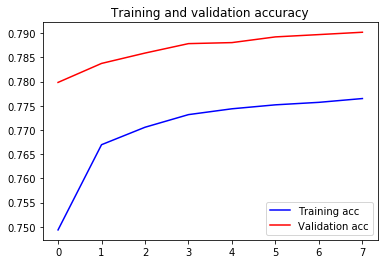

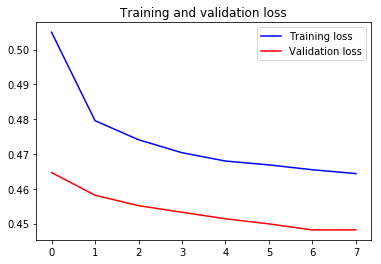

In [44]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Predict

In [45]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [46]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [47]:
predict("I love the music")

{'elapsed_time': 0.2817859649658203,
 'label': 'POSITIVE',
 'score': 0.9774266481399536}

In [48]:
predict("I hate the rain")

{'elapsed_time': 0.0836789608001709,
 'label': 'NEGATIVE',
 'score': 0.008031508885324001}

In [49]:
predict("i don't know what i'm doing")

{'elapsed_time': 0.0863790512084961,
 'label': 'NEGATIVE',
 'score': 0.3027966320514679}

### Confusion Matrix

In [50]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=0, batch_size=1024)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

CPU times: user 58.7 s, sys: 2.48 s, total: 1min 1s
Wall time: 45.4 s


In [51]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

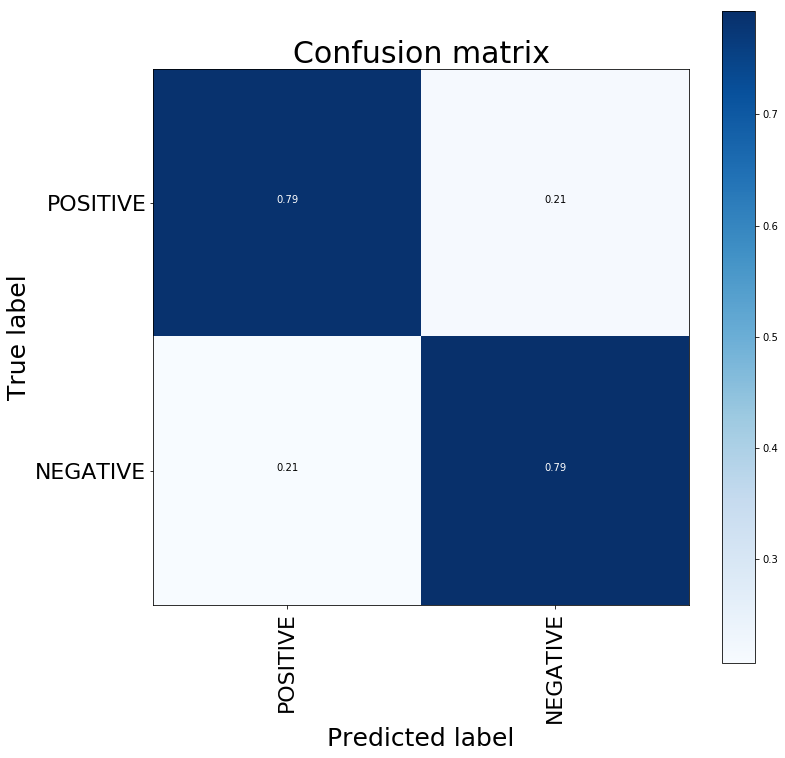

CPU times: user 637 ms, sys: 206 ms, total: 842 ms
Wall time: 606 ms


In [52]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

### Classification Report

In [53]:
print(classification_report(y_test_1d, y_pred_1d))

             precision    recall  f1-score   support

   NEGATIVE       0.79      0.79      0.79    159494
   POSITIVE       0.79      0.79      0.79    160506

avg / total       0.79      0.79      0.79    320000



### Accuracy Score

In [54]:
accuracy_score(y_test_1d, y_pred_1d)

0.790759375

### Save model

In [55]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

2019-03-12 19:06:23,150 : INFO : saving Word2Vec object under model.w2v, separately None
2019-03-12 19:06:23,153 : INFO : not storing attribute vectors_norm
2019-03-12 19:06:23,156 : INFO : not storing attribute cum_table
2019-03-12 19:06:23,501 : INFO : saved model.w2v


NameError: name 'predict' is not defined